C:\Users\noorm\AppData\Local\Temp\ipykernel_8592\2577701582.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\noorm\AppData\Local\Temp\ipykernel_8592\2577701582.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

Shape: (303, 14)
Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


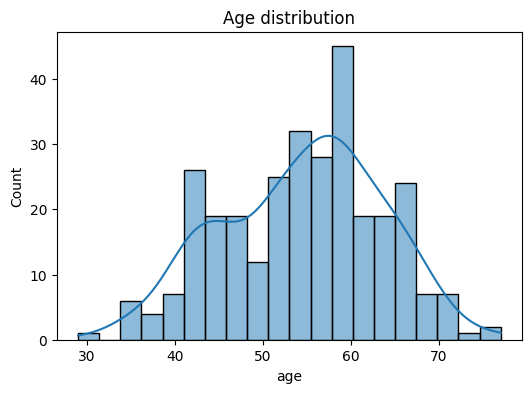

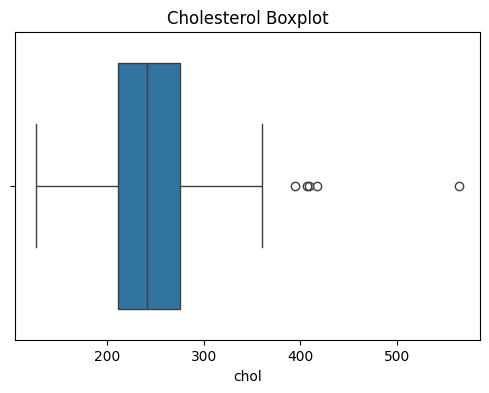

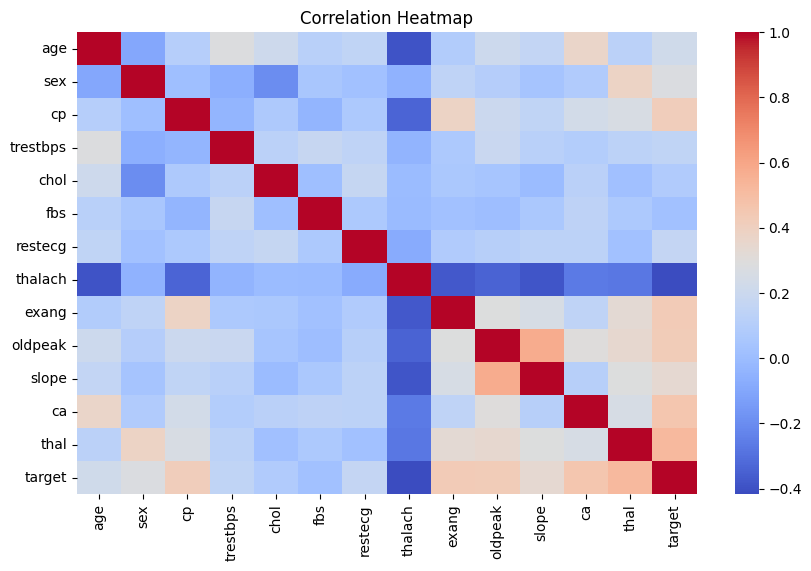

✅ Saved cleaned dataset at C:\Users\noorm\Documents\Heart_Disease_Project\data\heart_disease_cleaned.csv


In [5]:
# %% [markdown]
# 01_data_preprocessing.ipynb
# This notebook loads the Cleveland Heart Disease dataset, performs cleaning, preprocessing,
# exploratory data analysis (EDA), and saves processed data.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from pathlib import Path
import joblib

# %%
# Project folders
ROOT = Path("..").resolve()

DATA_DIR = ROOT / "data"
RESULTS_DIR = ROOT / "results"
MODELS_DIR = ROOT / "models"
for d in [DATA_DIR, RESULTS_DIR, MODELS_DIR]:
    d.mkdir(exist_ok=True)

RAW_CSV = DATA_DIR / "heart_disease.csv"        # renamed from processed.cleveland.data
CLEANED_CSV = DATA_DIR / "heart_disease_cleaned.csv"

# %%
# Define column names (from UCI dataset description)
columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
]

# Load dataset with column names, handle "?" as NaN
df = pd.read_csv(RAW_CSV, header=None, names=columns, na_values="?")

# Convert target into binary (0 = no disease, 1 = disease)
df["target"] = df["target"].apply(lambda x: 1 if x > 0 else 0)

# Handle missing values (replace with median for numeric columns)
for col in df.columns:
    if df[col].dtype != "object":  # numeric
        df[col].fillna(df[col].median(), inplace=True)
    else:  # categorical (like thal, ca)
        df[col].fillna(df[col].mode()[0], inplace=True)

print("Shape:", df.shape)
df.head()

# %%
# Check missing values
print("Missing values per column:")
print(df.isnull().sum())

# %%
# Exploratory plots
plt.figure(figsize=(6,4))
sns.histplot(df['age'], kde=True, bins=20)
plt.title("Age distribution")
plt.savefig(RESULTS_DIR / "hist_age.png")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=df['chol'])
plt.title("Cholesterol Boxplot")
plt.savefig(RESULTS_DIR / "box_chol.png")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.savefig(RESULTS_DIR / "correlation_heatmap.png")
plt.show()

# %%
# Preprocessing pipeline
y = df["target"]
X = df.drop(columns=["target"])

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Save preprocessor
joblib.dump(preprocessor, MODELS_DIR / "preprocessor.pkl")

# Apply preprocessing and split
X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, stratify=y, random_state=42
)

# Save cleaned dataset
df.to_csv(CLEANED_CSV, index=False)
print("✅ Saved cleaned dataset at", CLEANED_CSV)
